# CRF sequence tagging for Movie Queries

This project involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

It involves reading in, pre-processing, training and developing our tagger on the training data from *trivia10k13train.bio.txt*, and finally testing our tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in our development process. We are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final task is to optimize the performance by all legal means neccessary (except looking at the test data).

In [1]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

In [6]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [10]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [11]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [12]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [13]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [14]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [15]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [16]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [17]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['I-Quote', 'B-Origin', 'I-Plot', 'I-Relationship', 'B-Soundtrack', 'B-Quote', 'B-Director', 'I-Actor', 'B-Year', 'B-Genre', 'B-Opinion', 'B-Actor', 'I-Genre', 'I-Year', 'I-Origin', 'I-Soundtrack', 'I-Director', 'B-Relationship', 'I-Character_Name', 'O', 'B-Award', 'B-Character_Name', 'B-Plot', 'I-Award', 'I-Opinion'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


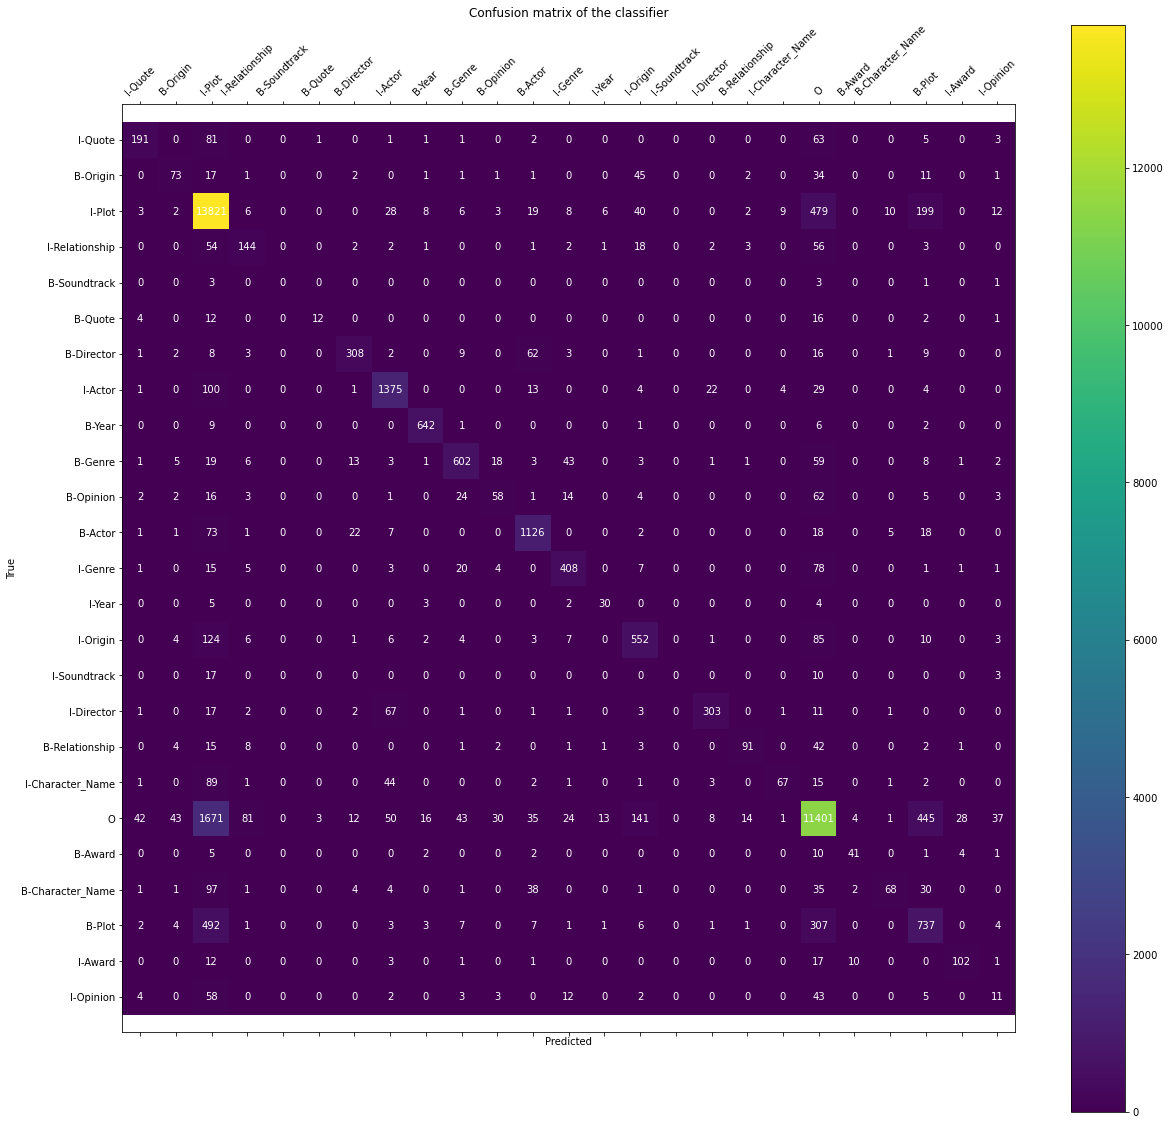

In [19]:
confusion_matrix_heatmap(y_test, preds)

In [20]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [21]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [22]:
print_transition_weights(ct._tagger.info().transitions.items())

8.730936 B-Actor  -> I-Actor
8.345982 B-Plot   -> I-Plot
8.062881 B-Director -> I-Director
7.851024 B-Origin -> I-Origin
7.728286 I-Plot   -> I-Plot
7.557302 I-Quote  -> I-Quote
7.400516 B-Character_Name -> I-Character_Name
7.347592 I-Origin -> I-Origin
7.270472 B-Relationship -> I-Relationship
7.168646 B-Quote  -> I-Quote
7.019230 I-Relationship -> I-Relationship
6.874782 I-Soundtrack -> I-Soundtrack
6.792831 I-Opinion -> I-Opinion
6.739054 B-Genre  -> I-Genre
6.682199 B-Soundtrack -> I-Soundtrack
6.580473 B-Award  -> I-Award
6.441732 B-Opinion -> I-Opinion
6.428294 I-Award  -> I-Award
6.362482 I-Genre  -> I-Genre
6.348037 I-Actor  -> I-Actor
6.225893 I-Character_Name -> I-Character_Name
5.430455 I-Director -> I-Director
4.809019 I-Year   -> I-Year
4.082752 B-Year   -> I-Year
3.773733 B-Character_Name -> B-Plot
3.563915 O        -> O
3.562699 I-Character_Name -> B-Plot
3.277145 O        -> B-Plot
3.199695 B-Plot   -> B-Character_Name
3.091597 B-Opinion -> B-Genre
3.030532 O        -> 

In [23]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [24]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.191234 B-Year   HAS_NUM
4.378852 B-Genre  WORD_animated
4.376891 I-Year   WORD_s
3.280298 B-Genre  WORD_thriller
2.998992 B-Quote  WORD_i
2.986864 I-Genre  WORD_animated
2.968166 B-Genre  WORD_action
2.913375 B-Plot   WORD_a
2.910979 B-Opinion WORD_blockbuster
2.682290 B-Award  WORD_oscar
2.667863 B-Genre  WORD_animation
2.596255 B-Relationship SUF_uel
2.572959 B-Director WORD_disney
2.563763 B-Opinion WORD_masterpiece
2.552841 I-Genre  WORD_fiction
2.542230 B-Award  SUF_car
2.527780 B-Relationship WORD_remake
2.471652 B-Actor  WORD_cher
2.439679 B-Genre  WORD_horror
2.427487 I-Genre  WORD_white
2.413953 B-Relationship WORD_sequel
2.410295 I-Genre  WORD_thriller
2.378248 B-Genre  WORD_slasher
2.370675 B-Genre  WORD_comedy
2.337885 B-Origin WORD_adapted
2.304871 I-Actor  WORD_cage
2.276711 B-Genre  WORD_documentary
2.231418 B-Director SUF_xar
2.231418 B-Director WORD_pixar
2.227497 B-Genre  WORD_romance
2.184817 B-Genre  WORD_war
2.180846 B-Award  WORD_won
2.177721 B-Plot   WORD_an
2.

# 1. Split the training data into 80% training, 20% development set
Here, we are splitting the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which we will use for training our CRF, and the remaining 20% for testing. Once we've done this, we will re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and we obtain the classification report output and confusion heatmap output for the results of testing. We will record the results by saving the classification report output as a string somewhere in the notebook for future reference as we go through.


In [25]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(raw_training_data,train_size = 0.8,  test_size=0.2 , shuffle = False)

def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

training_data = [preProcess(example) for example in x_train]

In [26]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [27]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")


# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:

x_test = [preProcess(example) for example in x_test]
print(len(x_test), "instances")
print(sum([len(sent) for sent in x_test]), "words")


print("testing tagger...")
preds = []
y_test = []
length = 0
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")



training tagger...
done
1564 instances
31304 words
testing tagger...
done


In [28]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.12      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.48      0.24      0.32       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86      0.66      0.74       456
         I-Ge

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['I-Quote', 'B-Origin', 'I-Plot', 'I-Relationship', 'B-Soundtrack', 'B-Quote', 'B-Director', 'I-Actor', 'B-Year', 'B-Genre', 'B-Opinion', 'B-Actor', 'I-Genre', 'I-Year', 'I-Origin', 'I-Soundtrack', 'I-Director', 'B-Relationship', 'I-Character_Name', 'O', 'B-Award', 'B-Character_Name', 'B-Plot', 'I-Award', 'I-Opinion'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


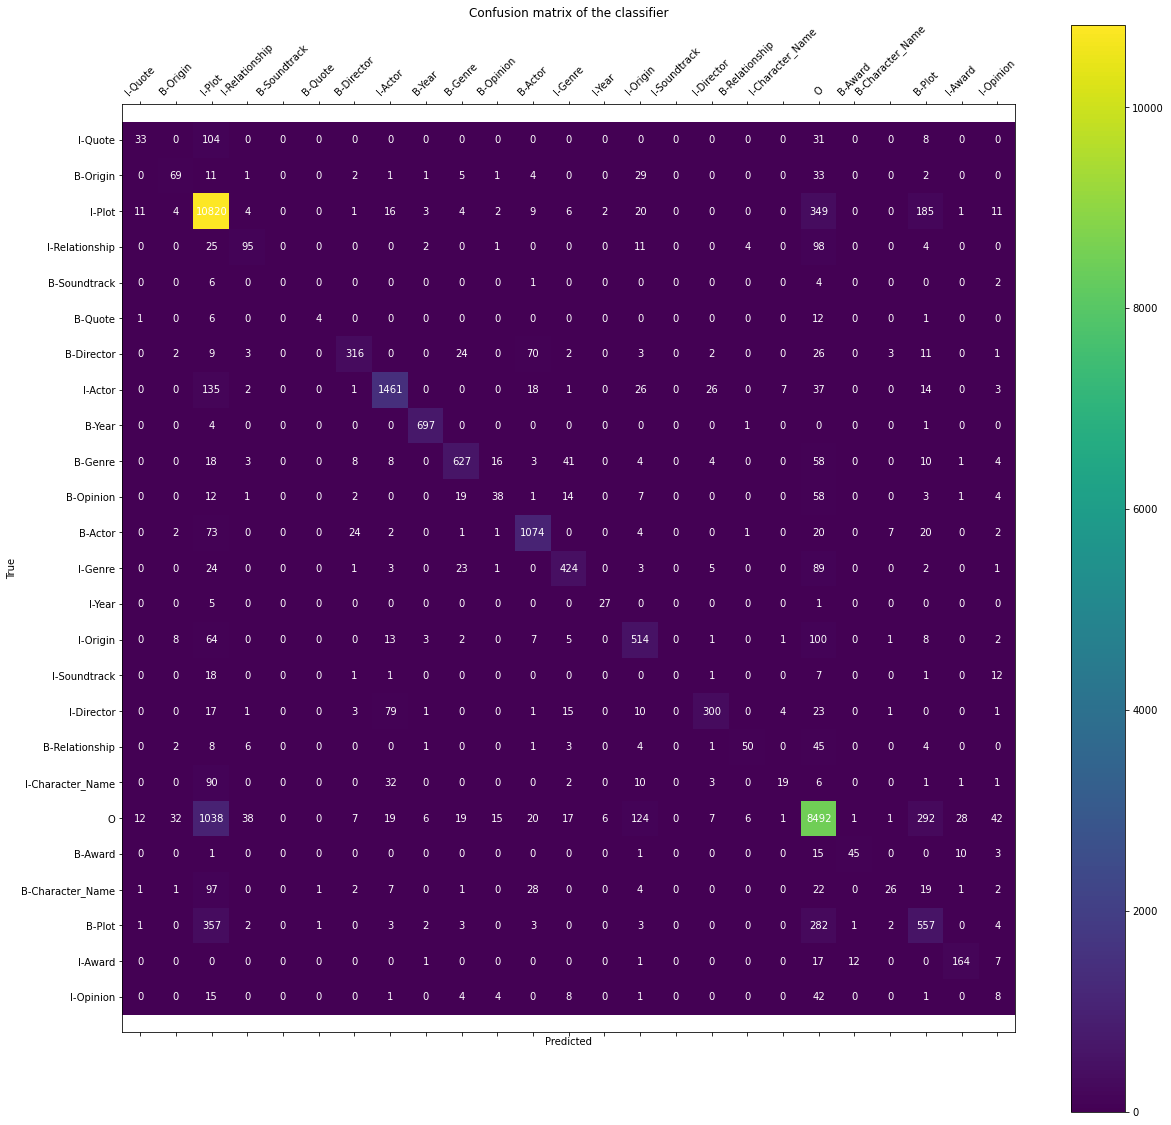

In [29]:


def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    
    
confusion_matrix_heatmap(y_test, preds)

# 2. Error analysis 1: False positives

Performing error analyses is a key part of improving our NLP applications. For the 5 classes which have the lowest precision, according to the results table from our 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). 


In [30]:
import itertools
output = (classification_report(y_test, preds, output_dict = True))
#print(output)
sorted_dict = {}
sorted_dict2 = {}
sliced_dict = {}

for key,value in output.items():   #Extracting the precision column from the dictionary
    if type(value) == dict:
        if (key != "macro avg") and (key!= "weighted avg"):
            sorted_dict.__setitem__(key,value['precision'])

sorted_dict2 = sorted(sorted_dict.items(), key=lambda x: x[1])
#print(sorted_dict2)
sliced_dict = dict(itertools.islice(sorted_dict2, 5))
print(sliced_dict)

list1=[]
for x in list(sliced_dict):
    list1.append(x)
#print(list1)

abc = []
fp_sentences = []

for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for s in range(0,len(sent)):
        if (sent_preds[s]!=sent_true[s]):
            for i in range(0,len(list1)):
                if (sent_preds[s]==list1[i]):
                    if sent not in abc:
                        abc.append(sent)
    
print(len(abc))
print("The sentences with false positives for the given 5 classes with lowest precision are: \n")   
for i in abc:
    #print(i)
    for j in i:
        print(j[0], end = ' ')
        fp_sentences.append(j[0])
    print("\n")


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'B-Soundtrack': 0.0, 'I-Soundtrack': 0.0, 'I-Opinion': 0.07272727272727272, 'B-Opinion': 0.4810126582278481, 'B-Plot': 0.4868881118881119}
620
The sentences with false positives for the given 5 classes with lowest precision are: 

on a vacation in paris one of three travelers is mistaken for a british heiress 

one of the first disney animated films with beautiful images few lines and a lot of music 

orson welles directed and starred in this 1965 movie about the career of shakespeare s sir john falstaff as roistering companion to young prince hal 

orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some 

paul giamatti and thomas haden church are two men reaching middle age with not much to show but disappointment in this 2004 comedy romance movie 

paul newman starred in this 1977 hockey movie about the struggles of a minor league team 

perseus mortal son of zeus battles the minions of the underworld to stop them from conq

# 3. Error analysis 2: False negatives

For the 5 classes which have the lowest recall, according to the results table from our 20% development data, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger).


In [31]:
import itertools
output = (classification_report(y_test, preds, output_dict = True))
#print(output)
sorted_dict = {}
sorted_dict2 = {}
sliced_dict = {}

for key,value in output.items():   #Extracting the precision column from the dictionary
    if type(value) == dict:
        if (key != "macro avg") and (key!= "weighted avg"):
            sorted_dict.__setitem__(key,value['recall'])

sorted_dict2 = sorted(sorted_dict.items(), key=lambda x: x[1])
#print(sorted_dict2)
sliced_dict = dict(itertools.islice(sorted_dict2, 5))
print(sliced_dict)

list1_fn=[]
for x in list(sliced_dict):
    list1_fn.append(x)
#print(list1_fn)


abc_fn = []
fn_sentences = []
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    for s in range(0,len(sent)):
        if (sent_preds[s]!=sent_true[s]):
            for i in range(0,len(list1_fn)):
                if (sent_true[s]==list1_fn[i]):
                    if sent not in abc_fn:
                        abc_fn.append(sent)
                        
print(len(abc_fn))
    

print("The sentences with false positives for the given 5 classes with lowest precision are: \n")   
for i in abc_fn:
    for j in i:
        print(j[0], end = ' ')
        fn_sentences.append(j[0])
    print("\n")
    



/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'B-Soundtrack': 0.0, 'I-Soundtrack': 0.0, 'I-Opinion': 0.09523809523809523, 'I-Character_Name': 0.11515151515151516, 'B-Character_Name': 0.12264150943396226}
202
The sentences with false positives for the given 5 classes with lowest precision are: 

one of the most memorable scenes from this film involve a boy riding his bike through the sky 

orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some 

paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer 

penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama 

perseus mortal son of zeus battles the minions of the underworld to stop them from conquering the earth and the heavens in this 2010 action adventure fantasy 

peter jackson directed this smash hit starring jack black as a 1930 s film maker on a mission to

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4. Incorporating POS tags as features
Using the CRF part-of-speech (POS) tagger to add POS tags to the words in the training data. Note the CRF tagger only takes strings as input so we will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. 

In [32]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [33]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(raw_training_data,train_size = 0.8,  test_size=0.2 , shuffle = False)


In [34]:
def preProcess1(example):
    
    """returns new (token, bio-tag) pairs with preprocessing applied to the words

    example = [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), 
        ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), 
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), 
        ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]"""


    # a postagger for use in exercises
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")

    final_list = []


        
    for i in example:
        word = i[0]       # Extracting the words from training data
        classes = i[1]     #Extracting the classes ('I-Plot, A-Actor' etc) from training data
        POS_tags = posttagger.tag([word])     # Tagging the words from training data using POS tagger
        POS_tagged_words = word+"@"+POS_tags[0][1]  # concatenating the words and the POS tags with a special symbol '@'.
        final_list.append((POS_tagged_words,classes))  # Appending the words@POStag with the classes 
        

    
    return final_list


In [35]:
training_data = [preProcess1(example) for example in x_train]

In [36]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features1(tokens,idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = (tokens[idx].split('@'))
    word_token = token[0]
    POS_token = token[1]
    feature_list = []
    
    

    if not word_token:
        return feature_list
    
    # Capitalization
    if word_token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, word_token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in word_token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(word_token) > 1:
        feature_list.append("SUF_" + word_token[-1:])
    if len(word_token) > 2:
        feature_list.append("SUF_" + word_token[-2:])
    if len(word_token) > 3:
        feature_list.append("SUF_" + word_token[-3:])
        
    feature_list.append("WORD_" + word_token + ", POStag_" + POS_token)
    #print(feature_list)
    
    
    return feature_list   

In [37]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features1)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")


# load tagger from saved file
ct = CRFTagger(feature_func=get_features1)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:

x_test = [preProcess1(example) for example in x_test]
print(len(x_test), "instances")
print(sum([len(sent) for sent in x_test]), "words")


print("testing tagger...")
preds = []
y_test = []
length = 0
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

training tagger...
done
1564 instances
31304 words
testing tagger...
done


In [38]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.12      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.48      0.24      0.32       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86      0.66      0.74       456
         I-Ge

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['I-Quote', 'B-Origin', 'I-Plot', 'I-Relationship', 'B-Soundtrack', 'B-Quote', 'B-Director', 'I-Actor', 'B-Year', 'B-Genre', 'B-Opinion', 'B-Actor', 'I-Genre', 'I-Year', 'I-Origin', 'I-Soundtrack', 'I-Director', 'B-Relationship', 'I-Character_Name', 'O', 'B-Award', 'B-Character_Name', 'B-Plot', 'I-Award', 'I-Opinion'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


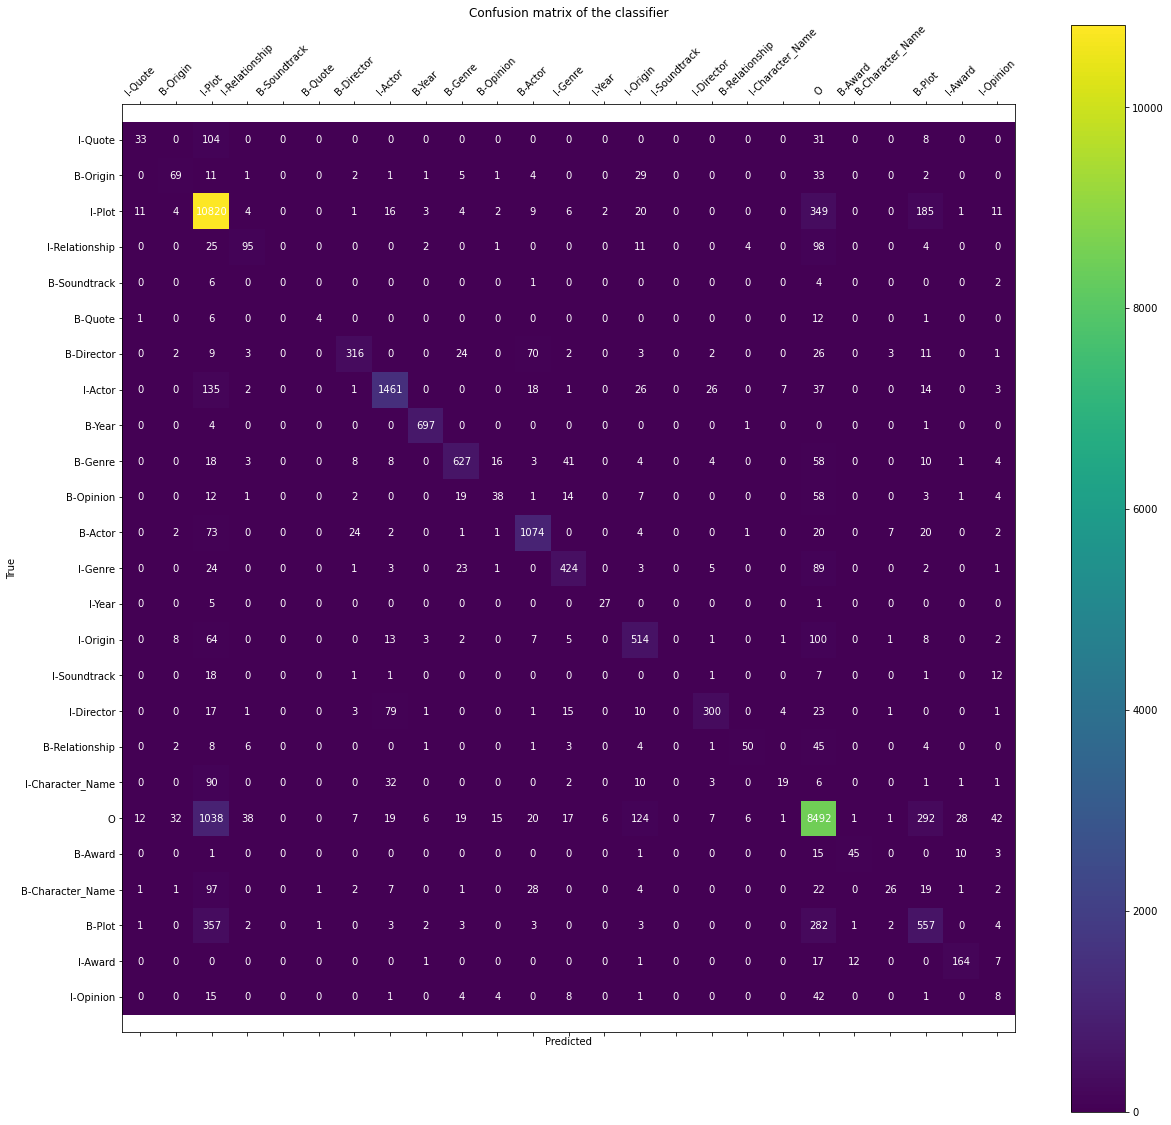

In [39]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    
confusion_matrix_heatmap(y_test, preds)

# 5. Feature experimentation and other optimization for optimal macro average.
Now, we will experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on our 20% development data. Iteratively we will try different functions, briefly describe the method and record the results in the classification report format.

We could try more suffixes/prefixes of the current word than those currently extracted, use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags).

After our feature engineering, for even better performance we have tried optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

In [40]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(raw_training_data,train_size = 0.8,  test_size=0.2 , shuffle = False)

In [41]:
def preProcess1(example):
    
    """returns new (token, bio-tag) pairs with preprocessing applied to the words

    example = [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), 
        ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), 
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), 
        ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]"""


    # a postagger for use in exercises
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")

    final_list = []


        
    for i in example:
        word = i[0]       # Extracting the words from training data
        classes = i[1]     #Extracting the classes ('I-Plot, A-Actor' etc) from training data
        POS_tags = posttagger.tag([word])     # Tagging the words from training data using POS tagger
        POS_tagged_words = word+"@"+POS_tags[0][1]  # concatenating the words and the POS tags with a special symbol '@'.
        final_list.append((POS_tagged_words,classes))  # Appending the words@POStag with the classes 
        

    
    return final_list

In [42]:
training_data = [preProcess1(example) for example in x_train]

In [43]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features1(tokens,idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    
    token = ((tokens[idx]).split('@'))  #Splitting the words and the POS Tags
    word_token = token[0]   #Storing the word 
    POS_token = token[1]    #Storing the POS tags
    feature_list = []
    
    

    if not word_token:
        return feature_list
    
    feature_list.append("Length = " + str(len(word_token)))
    
    if (idx==0):
        feature_list.append("is_first_word")
    
    
    if (idx==len(tokens)-1):
        feature_list.append("is_last_word")
    
    # Capitalization
    if word_token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, word_token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in word_token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 4
    if len(word_token) > 1:
        feature_list.append("SUF_" + word_token[-1:])
    if len(word_token) > 2:
        feature_list.append("SUF_" + word_token[-2:])
    if len(word_token) > 3:
        feature_list.append("SUF_" + word_token[-3:])
    if len(word_token) > 4:
        feature_list.append("SUF_" + word_token[-4:])
        
        
    # Prefix up to length 4
    if len(word_token) > 1:
        feature_list.append("PRE_" + word_token[:1])
    if len(word_token) > 2:
        feature_list.append("PRE_" + word_token[:2])
    if len(word_token) > 3:
        feature_list.append("PRE_" + word_token[:3])
    if len(word_token) > 4:
        feature_list.append("PRE_" + word_token[:4])
        
    if idx!=0:    #added a feature for the previous word.
        token3 = tokens[idx-1]
        token3 = token3.split('@')
        token3 = token3[0]
        feature_list.append("Previous Word_"+ token3)
        
    feature_list.append("WORD_" + word_token + ", POStag_" + POS_token)
    
    
    if idx!=(len(tokens)-2):      #added a feature for the next two words.
        if idx!=(len(tokens)-1):
            token1 = tokens[idx+1]
            token1 = token1.split('@')
            token1 = token1[0]
            #print(token1)
            token2 = (tokens[idx+2])
            token2 = token2.split('@')
            token2 = token2[0]
            #print(token2)
            feature_list.append("Next Two Words_" + token1 + "," + token2 )
        
    
    
    #print(feature_list)
    return feature_list


In [44]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features1)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")


# load tagger from saved file
ct = CRFTagger(feature_func=get_features1)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:

x_test = [preProcess1(example) for example in x_test]
print(len(x_test), "instances")
print(sum([len(sent) for sent in x_test]), "words")


print("testing tagger...")
preds = []
y_test = []
length = 0
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

training tagger...
done
1564 instances
31304 words
testing tagger...
done


In [45]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1231
         B-Award       0.75      0.65      0.70        75
B-Character_Name       0.80      0.33      0.46       212
      B-Director       0.90      0.76      0.83       472
         B-Genre       0.90      0.84      0.87       805
       B-Opinion       0.61      0.37      0.46       160
        B-Origin       0.59      0.47      0.52       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.78      0.29      0.42        24
  B-Relationship       0.81      0.53      0.64       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.93      0.93      1731
         I-Award       0.82      0.78      0.80       202
I-Character_Name       0.83      0.30      0.44       165
      I-Director       0.92      0.76      0.83       456
         I-Ge

#Classification report after adding the features to get_features function

                    precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1231
         B-Award       0.75      0.65      0.70        75
B-Character_Name       0.74      0.33      0.46       212
      B-Director       0.91      0.77      0.83       472
         B-Genre       0.89      0.84      0.87       805
       B-Opinion       0.61      0.36      0.45       160
        B-Origin       0.57      0.45      0.50       159
          B-Plot       0.49      0.45      0.47      1221
         B-Quote       0.86      0.25      0.39        24
  B-Relationship       0.82      0.53      0.64       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.92      0.93      1731
         I-Award       0.81      0.78      0.80       202
I-Character_Name       0.76      0.30      0.43       165
      I-Director       0.92      0.76      0.83       456
         I-Genre       0.82      0.78      0.80       576
       I-Opinion       0.42      0.26      0.32        84
        I-Origin       0.73      0.68      0.70       729
          I-Plot       0.87      0.94      0.90     11448
         I-Quote       0.92      0.31      0.47       176
  I-Relationship       0.66      0.45      0.54       240
    I-Soundtrack       1.00      0.05      0.09        41
          I-Year       0.79      0.67      0.72        33
               O       0.85      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.80      0.58      0.64     31304
    weighted avg       0.85      0.85      0.85     31304

(0.8004030378492045, 0.5795477583011504, 0.6353858164613881, None)

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['I-Quote', 'B-Origin', 'I-Plot', 'I-Relationship', 'B-Soundtrack', 'B-Quote', 'B-Director', 'I-Actor', 'B-Year', 'B-Genre', 'B-Opinion', 'B-Actor', 'I-Genre', 'I-Year', 'I-Origin', 'I-Soundtrack', 'I-Director', 'B-Relationship', 'I-Character_Name', 'O', 'B-Award', 'B-Character_Name', 'B-Plot', 'I-Award', 'I-Opinion'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


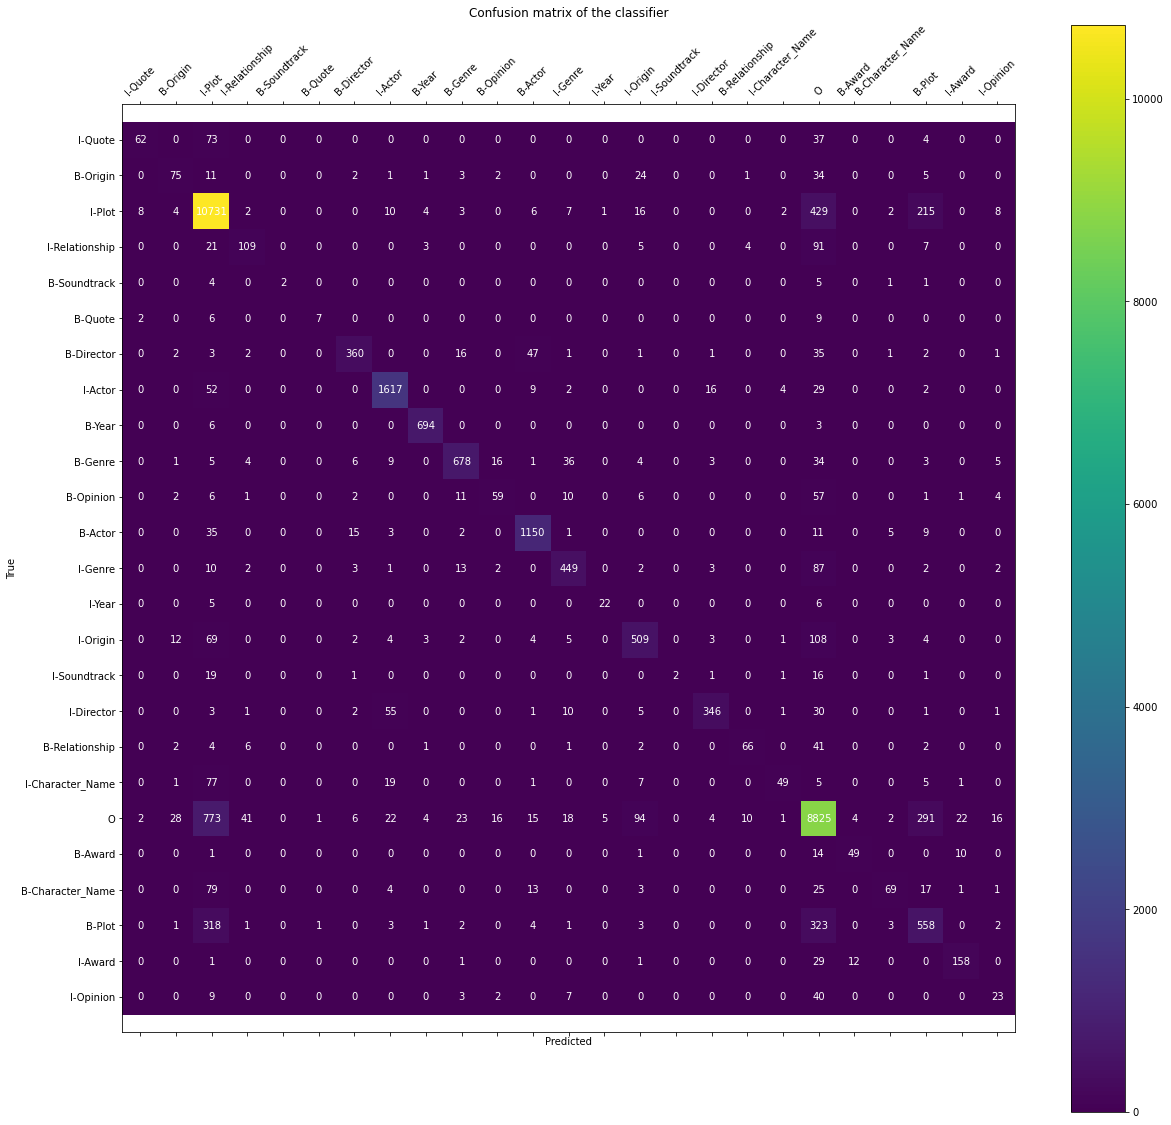

In [46]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    
confusion_matrix_heatmap(y_test, preds)

In [47]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(raw_training_data,train_size = 0.8,  test_size=0.2 , shuffle = False)

In [48]:
training_data = [preProcess1(example) for example in x_train]

In [49]:
#Modifing the minfreq


# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
#ct = CRFTagger(feature_func=get_features1)  # initialize tagger with get_features function
ct = CRFTagger(feature_func=get_features1, training_opt={"c1":0.2,"c2":0.2})

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
#ct = CRFTagger(feature_func=get_features1)  # initialize tagger
ct = CRFTagger(feature_func=get_features1, training_opt={"c1":0.2,"c2":0.2})
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:

x_test = [preProcess1(example) for example in x_test]
#print(x_test)
#print(len(x_test), "instances")
#print(sum([len(sent) for sent in x_test]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")
#print(predicted)

training tagger...
done
testing tagger...
done


In [50]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.73      0.64      0.68        75
B-Character_Name       0.72      0.38      0.50       212
      B-Director       0.90      0.76      0.83       472
         B-Genre       0.89      0.85      0.87       805
       B-Opinion       0.59      0.38      0.46       160
        B-Origin       0.59      0.50      0.54       159
          B-Plot       0.49      0.45      0.47      1221
         B-Quote       0.67      0.33      0.44        24
  B-Relationship       0.80      0.54      0.64       125
    B-Soundtrack       0.75      0.23      0.35        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.93      0.94      0.93      1731
         I-Award       0.80      0.79      0.79       202
I-Character_Name       0.76      0.38      0.50       165
      I-Director       0.92      0.77      0.84       456
         I-Ge

#Classification report when the minfreq = 2

                    precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.75      0.65      0.70        75
B-Character_Name       0.75      0.33      0.45       212
      B-Director       0.90      0.76      0.82       472
         B-Genre       0.89      0.83      0.86       805
       B-Opinion       0.62      0.38      0.47       160
        B-Origin       0.55      0.44      0.49       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.75      0.25      0.38        24
  B-Relationship       0.81      0.53      0.64       125
    B-Soundtrack       0.50      0.08      0.13        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.93      0.93      1731
         I-Award       0.82      0.79      0.80       202
I-Character_Name       0.74      0.32      0.44       165
      I-Director       0.90      0.75      0.82       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.28      0.24      0.26        84
        I-Origin       0.73      0.68      0.70       729
          I-Plot       0.87      0.94      0.90     11448
         I-Quote       0.75      0.28      0.41       176
  I-Relationship       0.66      0.45      0.54       240
    I-Soundtrack       0.25      0.02      0.04        41
          I-Year       0.79      0.67      0.72        33
               O       0.85      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.73      0.57      0.62     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7317164664040393, 0.5731421881793213, 0.6221089149797558, None)



#Classification report when the minfreq = 3


                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1231
         B-Award       0.77      0.65      0.71        75
B-Character_Name       0.75      0.34      0.47       212
      B-Director       0.90      0.76      0.82       472
         B-Genre       0.88      0.82      0.85       805
       B-Opinion       0.61      0.37      0.46       160
        B-Origin       0.58      0.45      0.51       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.60      0.25      0.35        24
  B-Relationship       0.81      0.54      0.64       125
    B-Soundtrack       0.25      0.08      0.12        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.93      0.93      1731
         I-Award       0.81      0.80      0.80       202
I-Character_Name       0.71      0.33      0.45       165
      I-Director       0.90      0.74      0.81       456
         I-Genre       0.80      0.77      0.78       576
       I-Opinion       0.27      0.24      0.25        84
        I-Origin       0.74      0.69      0.71       729
          I-Plot       0.88      0.93      0.91     11448
         I-Quote       0.68      0.31      0.43       176
  I-Relationship       0.62      0.46      0.53       240
    I-Soundtrack       0.45      0.12      0.19        41
          I-Year       0.82      0.70      0.75        33
               O       0.85      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.72      0.58      0.63     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7207916945228096, 0.5816815560757368, 0.6298643114221203, None)


#Classification report when the minfreq = 4


                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1231
         B-Award       0.75      0.63      0.68        75
B-Character_Name       0.75      0.32      0.45       212
      B-Director       0.90      0.76      0.82       472
         B-Genre       0.88      0.82      0.85       805
       B-Opinion       0.59      0.32      0.41       160
        B-Origin       0.59      0.47      0.52       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.70      0.29      0.41        24
  B-Relationship       0.82      0.54      0.65       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.92      0.93      0.93      1731
         I-Award       0.81      0.80      0.80       202
I-Character_Name       0.68      0.32      0.43       165
      I-Director       0.90      0.75      0.82       456
         I-Genre       0.81      0.78      0.79       576
       I-Opinion       0.18      0.14      0.16        84
        I-Origin       0.74      0.70      0.72       729
          I-Plot       0.87      0.94      0.90     11448
         I-Quote       0.70      0.32      0.44       176
  I-Relationship       0.61      0.50      0.55       240
    I-Soundtrack       1.00      0.15      0.26        41
          I-Year       0.79      0.67      0.72        33
               O       0.86      0.86      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.77      0.58      0.63     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7689284038065325, 0.5812836143578672, 0.6334994680557336, None)


Classification report when c1 = 0.25 and c2= 0.3

                 precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1231
         B-Award       0.73      0.63      0.68        75
B-Character_Name       0.76      0.34      0.47       212
      B-Director       0.90      0.77      0.83       472
         B-Genre       0.89      0.84      0.86       805
       B-Opinion       0.60      0.38      0.47       160
        B-Origin       0.59      0.47      0.52       159
          B-Plot       0.51      0.47      0.49      1221
         B-Quote       0.67      0.33      0.44        24
  B-Relationship       0.81      0.54      0.65       125
    B-Soundtrack       0.60      0.23      0.33        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.92      0.93      0.93      1731
         I-Award       0.79      0.80      0.80       202
I-Character_Name       0.74      0.35      0.47       165
      I-Director       0.91      0.77      0.83       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.23      0.24      0.24        84
        I-Origin       0.74      0.68      0.71       729
          I-Plot       0.88      0.94      0.90     11448
         I-Quote       0.74      0.38      0.50       176
  I-Relationship       0.68      0.47      0.56       240
    I-Soundtrack       0.70      0.17      0.27        41
          I-Year       0.79      0.70      0.74        33
               O       0.86      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.75      0.60      0.65     31304
    weighted avg       0.85      0.85      0.85     31304

(0.749520636521778, 0.5991952374415128, 0.650150837325279, None)

Classification report when c1 = 0.2 and c2= 0.2
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.72      0.63      0.67        75
B-Character_Name       0.73      0.36      0.48       212
      B-Director       0.90      0.77      0.83       472
         B-Genre       0.89      0.85      0.87       805
       B-Opinion       0.61      0.39      0.48       160
        B-Origin       0.56      0.47      0.51       159
          B-Plot       0.49      0.45      0.47      1221
         B-Quote       0.67      0.33      0.44        24
  B-Relationship       0.79      0.54      0.64       125
    B-Soundtrack       0.75      0.23      0.35        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.94      0.93      1731
         I-Award       0.78      0.81      0.80       202
I-Character_Name       0.74      0.36      0.49       165
      I-Director       0.92      0.77      0.84       456
         I-Genre       0.83      0.78      0.80       576
       I-Opinion       0.42      0.30      0.35        84
        I-Origin       0.73      0.68      0.71       729
          I-Plot       0.88      0.93      0.90     11448
         I-Quote       0.74      0.38      0.50       176
  I-Relationship       0.71      0.45      0.55       240
    I-Soundtrack       1.00      0.17      0.29        41
          I-Year       0.80      0.73      0.76        33
               O       0.86      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.77      0.60      0.66     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7731889972127022, 0.604376683160191, 0.6575428865611712, None)


# TRAINING AND TESTING ON RAW DATA

In [51]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")

In [52]:
training_data = [preProcess1(example) for example in raw_training_data]

In [53]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess1(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features1, training_opt={"c1":0.2,"c2":0.2}) # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features1, training_opt={"c1":0.2,"c2":0.2})  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [54]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1274
         B-Award       0.72      0.74      0.73        66
B-Character_Name       0.71      0.45      0.55       283
      B-Director       0.86      0.84      0.85       425
         B-Genre       0.82      0.79      0.81       789
       B-Opinion       0.50      0.40      0.44       195
        B-Origin       0.47      0.37      0.41       190
          B-Plot       0.51      0.49      0.50      1577
         B-Quote       0.77      0.36      0.49        47
  B-Relationship       0.80      0.57      0.67       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.92      0.93      0.92      1553
         I-Award       0.79      0.82      0.81       147
I-Character_Name       0.74      0.52      0.61       227
      I-Director       0.90      0.85      0.87       411
         I-Ge

/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['I-Quote', 'B-Origin', 'I-Plot', 'I-Relationship', 'B-Soundtrack', 'B-Quote', 'B-Director', 'I-Actor', 'B-Year', 'B-Genre', 'B-Opinion', 'B-Actor', 'I-Genre', 'I-Year', 'I-Origin', 'I-Soundtrack', 'I-Director', 'B-Relationship', 'I-Character_Name', 'O', 'B-Award', 'B-Character_Name', 'B-Plot', 'I-Award', 'I-Opinion'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


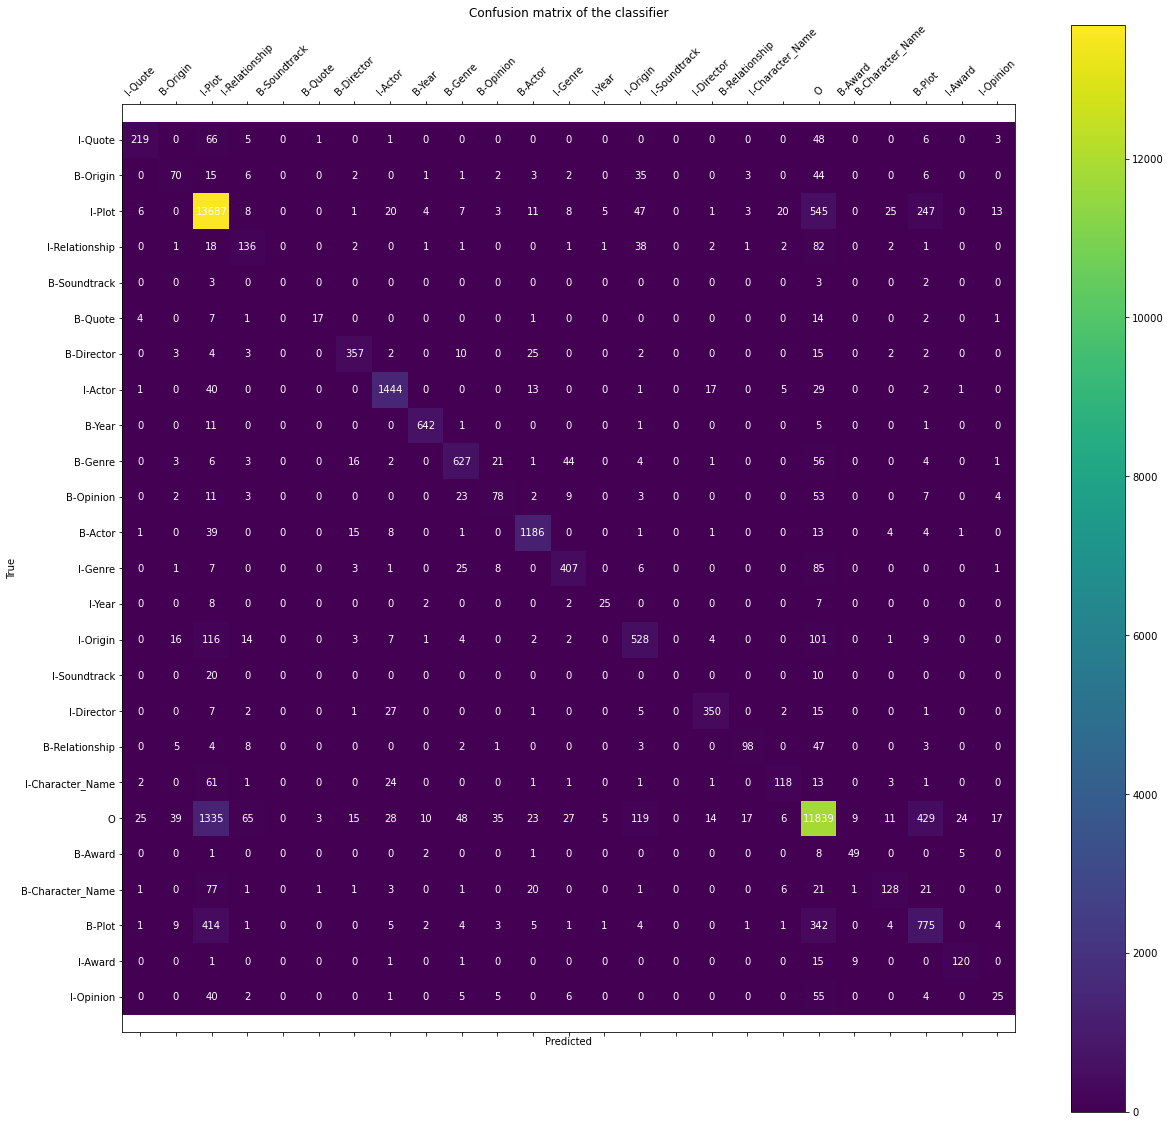

In [55]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    
confusion_matrix_heatmap(y_test, preds)